# 量子神经网络初体验

[![下载Notebook](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/resource/_static/logo_notebook.svg)](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/notebook/master/mindquantum/zh_cn/advanced/mindspore_initial_experience_of_quantum_neural_network.ipynb)&emsp;
[![下载样例代码](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/resource/_static/logo_download_code.svg)](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/notebook/master/mindquantum/zh_cn/advanced/mindspore_initial_experience_of_quantum_neural_network.py)&emsp;
[![查看源文件](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/resource/_static/logo_source.svg)](https://gitee.com/mindspore/docs/blob/master/docs/mindquantum/docs/source_zh_cn/advanced/initial_experience_of_quantum_neural_network.ipynb)

## 量子神经网络的结构

在MindSpore Quantum中，量子神经网络（Quantum Neural Network, QNN）的结构如下图所示，其通常由三部分构成：

（1）一个（或多个）编码线路，用于将经典数据编码到量子数据（通常称为Encoder）；

（2）一个（或多个）训练线路，用于训练带参量子门中的参数（通常称为Ansatz）；

（3）一个（或多个）测量，用于检测测量值（例如在`Z`方向上测量，就是某个量子比特的量子态在`Z`轴上的投影，该测量得到的是量子态关于泡利`Z`算符（不限定于泡利`Z`算符，换成其他的算符亦可）的期望值）是否接近于目标期望值。

![mindquantum](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/docs/mindquantum/docs/source_zh_cn/images/mq_mix_neural_network_cn.png)

下面，我们通过一个简单的例子来体验一下如何使用MindSpore Quantum。

## 简单的例子

![example circuit](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/docs/mindquantum/docs/source_zh_cn/images/example_circuit.png)

我们搭建如上图所示的量子神经网络，其中Encoder由一个 [H](https://www.mindspore.cn/mindquantum/docs/zh-CN/master/core/gates/mindquantum.core.gates.HGate.html) 门，1个 [RX](https://www.mindspore.cn/mindquantum/docs/zh-CN/master/core/gates/mindquantum.core.gates.RX.html) 门、1个 [RY](https://www.mindspore.cn/mindquantum/docs/zh-CN/master/core/gates/mindquantum.core.gates.RY.html) 门和1个 [RZ](https://www.mindspore.cn/mindquantum/docs/zh-CN/master/core/gates/mindquantum.core.gates.RZ.html) 门构成，Ansatz由1个 [RX](https://www.mindspore.cn/mindquantum/docs/zh-CN/master/core/gates/mindquantum.core.gates.RX.html) 门和1个 [RY](https://www.mindspore.cn/mindquantum/docs/zh-CN/master/core/gates/mindquantum.core.gates.RY.html) 门构成，测量则是作用在第0位量子比特上的泡利`Z`算符。

问题描述：我们将Encoder看成是系统对初始量子态的误差影响（参数$\alpha_0, \alpha_1$​和$\alpha_2$​是将原经典数据经过预处理（可选）后得到的某个固定值，即为已知值，在此分别设为0.2, 0.3和0.4）。我们需要训练一个Ansatz来抵消掉这个误差，使得最后的量子态还是处于$|0\rangle$​态。

思路：对末态执行泡利`Z`算符测量，此时的测量值就是此时的量子态关于泡利`Z`算符的期望值。由于$|0\rangle$​​是算符`Z`的本征态，且本征值为1，容易知道

$$
\langle 0|Z|0\rangle=1.
$$

也就是说，目标期望值为1。可以通过测量得到的期望值来验证此时的状态是否为$|0\rangle$。

解决方案：通过训练Ansatz中的参数，希望测量值接近于目标期望值，换句话说，我们只需让测量值尽可能接近于$|0\rangle$态关于泡利`Z`算符对应的期望值，那么此时的状态就是$|0\rangle$，即Ansatz抵消了Encoder对初始量子态产生的误差。

## 环境准备

导入本教程所依赖的模块

In [1]:
import numpy as np                                          # 导入numpy库并简写为np
from mindquantum.core.circuit import Circuit                # 导入Circuit模块，用于搭建量子线路
from mindquantum.core.gates import H, RX, RY, RZ            # 导入量子门H, RX, RY, RZ
from mindquantum.core.parameterresolver import PRGenerator  # 导入参数生成器模块

## 搭建Encoder

根据图示的量子线路图，我们可以在MindSpore Quantum中搭建Encoder。

                 Circuit Summary                 
╭──────────────────────┬────────────────────────╮
│ Info                 │ value                  │
├──────────────────────┼────────────────────────┤
│ Number of qubit      │ 1                      │
├──────────────────────┼────────────────────────┤
│ Total number of gate │ 4                      │
│ Barrier              │ 0                      │
│ Noise Channel        │ 0                      │
│ Measurement          │ 0                      │
├──────────────────────┼────────────────────────┤
│ Parameter gate       │ 3                      │
│ 3 encoder parameters │ alpha0, alpha1, alpha2 │
╰──────────────────────┴────────────────────────╯

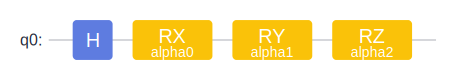

In [2]:
# pylint: disable=W0104
alpha = PRGenerator('alpha')          # 初始化参数生成器
encoder = Circuit()                   # 初始化量子线路
encoder += H.on(0)                    # H门作用在第0位量子比特
encoder += RX(alpha.new()).on(0)      # RX(alpha_0)门作用在第0位量子比特
encoder += RY(alpha.new()).on(0)      # RY(alpha_1)门作用在第0位量子比特
encoder += RZ(alpha.new()).on(0)      # RZ(alpha_2)门作用在第0位量子比特
encoder = encoder.no_grad()           # Encoder作为整个量子神经网络的第一层，不用对编码线路中的梯度求导数，因此加入no_grad()
encoder.as_encoder()                  # 将量子线路设置为encoder线路
encoder.summary()                     # 总结Encoder
encoder.svg()

从对Encoder的Summary中可以看到，该量子线路由4个量子门组成，其中有3个含参量子门且参数为$\alpha_0,\alpha_1,\alpha_2$​​​​，该量子线路调控的量子比特数为1。

然后，我们需要对Encoder中的参数进行赋值。由于Encoder中的参数$\alpha_0, \alpha_1$​和$\alpha_2$​分别为已知值0.2、0.3和0.4，因此可以直接对参数进行赋值，并打印此时的状态。

In [3]:
alpha0, alpha1, alpha2 = 0.2, 0.3, 0.4              # alpha0、alpha1、alpha2为已知的固定值，分别赋值0.2、0.3 和0.4
state = encoder.get_qs(pr={'alpha0': alpha0, 'alpha1': alpha1, 'alpha2': alpha2}, ket=True)
print(state)

(0.5669903122552596-0.1753906567580312j)¦0⟩
(0.800814626197614+0.08034947292077024j)¦1⟩


上述步骤为了展示MindSpore Quantum可以演化量子线路（若量子线路中的量子门带参数，则需要对参数赋值）并得到演化后的末态。从上述打印可以看到，演化后得到的末态为$|0\rangle$​​​和$|1\rangle$​​​组成的叠加态，各项对应的振幅为上述打印的状态左边对应的数值。

说明：

（1）通过调用量子线路的 [get_qs](https://www.mindspore.cn/mindquantum/docs/zh-CN/master/core/circuit/mindquantum.core.circuit.Circuit.html#mindquantum.core.circuit.Circuit.get_qs) 函数，我们能够得到该量子线路在全零态基础上演化出来的量子态。

（2）[get_qs](https://www.mindspore.cn/mindquantum/docs/zh-CN/master/core/circuit/mindquantum.core.circuit.Circuit.html#mindquantum.core.circuit.Circuit.get_qs) 的 `pr` 参数代表变分量子线路中的参数值，`ket` 表示是否将量子态输出为右矢形式。

## 搭建Ansatz

同样地，我们也可以在MindSpore Quantum中搭建Ansatz。

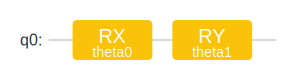

In [4]:
# pylint: disable=W0104
theta = PRGenerator('theta')                 # 初始化参数生成器
ansatz = Circuit()                           # 初始化量子线路
ansatz += RX(theta.new()).on(0)              # RX(theta_0)门作用在第0位量子比特
ansatz += RY(theta.new()).on(0)              # RY(theta_1)门作用在第0位量子比特
ansatz.as_ansatz()                           # 将量子线路设置成待训练线路
ansatz.svg()                                 # 打印量子线路

从对Ansatz的Summary中可以看到，该量子线路由2个量子门组成，其中有2个含参量子门且参数为$\theta_0, \theta_1$​​，该量子线路调控的量子比特数为1。

然后，对Ansatz中的参数进行赋值。由于Ansatz为需要训练的量子线路，因此Ansatz中的参数$\theta_0$​​和$\theta_1$​​可以随机设定，通常默认设为初始值0。我们同样可以打印此时的量子态，不过这并不是必要的步骤，只是为了再次熟悉一下 [get_qs](https://www.mindspore.cn/mindquantum/docs/zh-CN/master/core/circuit/mindquantum.core.circuit.Circuit.html#mindquantum.core.circuit.Circuit.get_qs) 函数。

In [5]:
theta0, theta1 = 0, 0                        # 对theta0、theta1进行赋值，设为初始值0、0
state = ansatz.get_qs(pr=dict(zip(ansatz.params_name, [theta0, theta1])), ket=True)
print(state)

1¦0⟩


从上述打印可以看到，此时的状态为$|0\rangle$​​且振幅为1。这是因为对于Ansatz来说，默认的输入量子态为$|0\rangle$​​，而且其中的参数$\theta_0$​​和$\theta_1$​​都为0，此时的 [RX(0)](https://www.mindspore.cn/mindquantum/docs/zh-CN/master/core/gates/mindquantum.core.gates.RX.html) 门和 [RY(0)](https://www.mindspore.cn/mindquantum/docs/zh-CN/master/core/gates/mindquantum.core.gates.RY.html) 门都相当于 [I](https://www.mindspore.cn/mindquantum/docs/zh-CN/master/core/gates/mindquantum.core.gates.IGate.html) 门，因此整个线路演化的过程就是$|0\rangle$​​经过$I\cdot I$，那么最后输出的态当然就是$|0\rangle$​​​了。

那么完整的量子线路就是Encoder加上Ansatz。

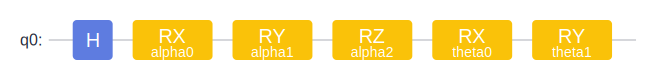

In [6]:
# pylint: disable=W0104
circuit = encoder.as_encoder() + ansatz.as_ansatz()                   # 完整的量子线路由Encoder和Ansatz组成
circuit.svg()

从对完整的量子线路的Summary中可以看到，该量子线路由6个量子门组成，其中有5个含参量子门且参数为$\alpha_0,\alpha_1,\alpha_2,\theta_0,\theta_1$​​​，该量子线路调控的量子比特数为1。

## 构建哈密顿量

我们对第0位量子比特执行泡利`Z`算符测量，构建对应的哈密顿量。

In [7]:
from mindquantum.core.operators import QubitOperator           # 导入QubitOperator模块，用于构造泡利算符
from mindquantum.core.operators import Hamiltonian             # 导入Hamiltonian模块，用于构建哈密顿量

ham = Hamiltonian(QubitOperator('Z0', -1))                     # 对第0位量子比特执行泡利Z算符测量，且将系数设置为-1，构建对应的哈密顿量
print(ham)

-1 [Z0]


从上述打印可以看到，此时构建的哈密顿量为对第0位量子比特执行泡利`Z`算符测量，且系数为-1。之所以将系数设为-1，是因为在量子神经网络的训练中，Ansatz中的参数的梯度会一直下降，同时测量值也会一直减少。如果最后收敛于-1，那么此时对应的量子态是$|1\rangle$而不是$|0\rangle$​，如下所示

$$
\langle 1|Z|1\rangle=-1.
$$

而我们所希望得到的是$|0\rangle$态。所以，将系数设为-1，那么当测量值为-1时，此时对应的量子态就是$|0\rangle$态，如下所示

$$
\langle 0|(-Z)|0\rangle=-1.
$$

说明：

（1）[QubitOperator](https://www.mindspore.cn/mindquantum/docs/zh-CN/master/core/operators/mindquantum.core.operators.QubitOperator.html) 是作用于量子比特的算子的总和，主要用于构造泡利算符；一般格式如下：`QubitOperator(term=None, coefficient=1.0)`；

（2）[Hamiltonian](https://www.mindspore.cn/mindquantum/docs/zh-CN/master/core/operators/mindquantum.core.operators.Hamiltonian.html) 是哈密顿量包装器，主要用于构建哈密顿量，一般格式如下：`Hamiltonian(QubitOperator('X0 Y2', 0.5))`，`X0` 和 `Y2` 表示泡利 `X` 算符作用在第0位量子比特，泡利 `Y` 算符作用在第2位量子比特，系数为0.5。

## 生成变分量子线路模拟算子

对于上述搭建的量子线路，我们可以在MindSpore Quantum生成一个变分量子线路模拟算子对其进行模拟。

首先，为了方便，我们对Encoder和Ansatz中的参数数组分别命名为encoder_names和ansatz_names。

In [8]:
encoder_names = encoder.params_name                   # Encoder中所有参数组成的数组，encoder.para_name系统会自动生成
ansatz_names = ansatz.params_name                     # Ansatz中所有参数组成的数组，ansatz.para_name系统会自动生成

print('encoder_names = ', encoder.params_name, '\nansatz_names =', ansatz.params_name)

encoder_names =  ['alpha0', 'alpha1', 'alpha2'] 
ansatz_names = ['theta0', 'theta1']


从上述打印可以看到，encoder_names为Encoder中所有参数$\alpha_0, \alpha_1, \alpha_2$​组成的数组，ansatz_names为Ansatz中所有参数$\theta_0,\theta_1$​组成的数组，这两个数组会在生成变分量子线路模拟算子时用到。

然后，我们通过 [Simulator](https://www.mindspore.cn/mindquantum/docs/zh-CN/master/simulator/mindquantum.simulator.Simulator.html) 模块得到变分量子线路演化和梯度求解的算子。

In [9]:
# 导入Simulator模块
from mindquantum.simulator import Simulator

# 生成一个基于mqvector后端的模拟器，并设置模拟器的比特数为量子线路的比特数。
sim = Simulator('mqvector', circuit.n_qubits)

# 获取模拟器基于当前量子态的量子线路演化以及期望、梯度求解算子
grad_ops = sim.get_expectation_with_grad(ham,
                                         circuit)

# Encoder中的alpha0, alpha1, alpha2这三个参数组成的数组，
# 将其数据类型转换为float32，并储存在encoder_data中。
# MindSpore Quantum支持多样本的batch训练，Encoder数组是两个维度，
# 第一个维度为样本，第二个维度为特征（即参数）
encoder_data = np.array([[alpha0, alpha1, alpha2]]).astype(np.float32)

# Ansatz中的theta0, theta1这两个参数组成的数组，将其数据类型转换为float32，
# 并储存在ansatzr_data中，Ansatz数据只有一个维度，特征（即参数）
ansatz_data = np.array([theta0, theta1]).astype(np.float32)

# 根据Encoder和Ansatz的数据，输出变分量子线路的测量值，Encoder中的参数的导数和Ansatz中的参数的导数
measure_result, encoder_grad, ansatz_grad = grad_ops(encoder_data, ansatz_data)

print('Measurement result: ', measure_result)
print('Gradient of encoder parameters: ', encoder_grad)
print('Gradient of ansatz parameters: ', ansatz_grad)

Measurement result:  [[0.29552022+0.j]]
Gradient of encoder parameters:  [[[0.+0.j 0.+0.j 0.+0.j]]]
Gradient of ansatz parameters:  [[[-0.37202556+0.j  0.87992317+0.j]]]


从上述打印可以看到，测量结果（期望值）为0.29552022，Encoder中的3个参数的导数为0，0，0（因为我们对Encoder设置了no_grad()），Ansatz中的2个参数的导数为-0.37202555，-0.87992316。

这里通过 [get_expectation_with_grad](https://www.mindspore.cn/mindquantum/docs/zh-CN/master/simulator/mindquantum.simulator.Simulator.html#mindquantum.simulator.Simulator.get_expectation_with_grad) 产生的只是一个算子，还不能进行训练，要把它放到量子神经网络里面才能进行训练。通过训练Ansatz中的参数，可以使得Ansatz中的参数的导数一直下降并接近于0，那么测量值也就会接近于-1。

说明：

（1）[Simulator](https://www.mindspore.cn/mindquantum/docs/zh-CN/master/simulator/mindquantum.simulator.Simulator.html) 的 [get_expectation_with_grad](https://www.mindspore.cn/mindquantum/docs/zh-CN/master/simulator/mindquantum.simulator.Simulator.html#mindquantum.simulator.Simulator.get_expectation_with_grad) 用于生成变分量子线路来模拟算子，一般格式如下：

```python

Simulator.get_expectation_with_grad(ham,
                                    circ_right,
                                    circ_left,
                                    simulator_left,
                                    parallel_worker=1)

```

此函数适用于计算如下模型：

$$E=\left<\varphi\right|U^\dagger_l(\theta) H U_r(\theta)\left|\psi\right>$$

其中`circ_right`是$U_r$，`circ_left`是$U_l$，当不提供时，默认跟`circ_right`是相同的线路，$\left|\psi\right>$是当前模拟器的量子态，$\left|\varphi\right>$是 `simulator_left` 中的量子态。 `parallel_worker`指定并行数，当需要编码的经典数据是一个batch时，合理设置此参数可以提高计算效率。

（2）MindSpore是一个全场景深度学习框架，旨在实现易开发、高效执行、全场景统一部署三大目标，提供支持异构加速的张量可微编程能力，支持云、服务器、边和端多种硬件平台。

## 搭建量子神经网络

In [10]:
# pylint: disable=W0104
from mindquantum.framework import MQLayer          # 导入MQLayer
import mindspore as ms                             # 导入mindspore

ms.set_seed(1)                                     # 设置生成随机数的种子
ms.set_context(mode=ms.PYNATIVE_MODE, device_target="CPU")

QuantumNet = MQLayer(grad_ops)
QuantumNet

MQLayer<
  (evolution): MQOps<1 qubit mqvector VQA Operator>
  >

上述打印可以看到，我们已经成功搭建了量子机器学习层，其可以无缝地跟MindSpore中其他的算子构成一张更大的机器学习网络。

说明：

（1）MindSpore Quantum中的量子线路梯度计算算子都是在`PYNATIVE_MODE`下的，因此需要设置MindSpore的运行模式。

（2）我们也可以通过如下代码方式搭建量子机器学习层，只是在MindSpore Quantum中，已经将下述过程封装打包，这样我们就可以直接利用 [MQLayer](https://www.mindspore.cn/mindquantum/docs/zh-CN/master/framework/layer/mindquantum.framework.MQLayer.html) 模块搭建量子机器学习层。对于更复杂的量子-经典混合神经网络，如下搭建方式会展示它的优势。

```python
from mindspore import nn

class MQLayer(nn.Cell):
    def __init__(self, expectation_with_grad, weight='normal'):
        super(MQLayer, self).__init__()
        self.evolution = MQOps(expectation_with_grad)
        weight_size = len(
            self.evolution.expectation_with_grad.ansatz_params_name)
        self.weight = Parameter(initializer(weight,
                                            weight_size,
                                            dtype=ms.float32),
                                name='ansatz_weight')

    def construct(self, x):
        return self.evolution(x, self.weight)

```

## 训练

我们采用 [Adam](https://www.mindspore.cn/docs/zh-CN/master/api_python/nn/mindspore.nn.Adam.html#mindspore.nn.Adam) 优化器优化Ansatz中的参数。

In [11]:
from mindspore.nn import Adam, TrainOneStepCell                   # 导入Adam模块和TrainOneStepCell模块

opti = Adam(QuantumNet.trainable_params(), learning_rate=0.5)     # 需要优化的是Quantumnet中可训练的参数，学习率设为0.5
net = TrainOneStepCell(QuantumNet, opti)

for i in range(200):
    res = net(ms.Tensor(encoder_data))
    if i % 10 == 0:
        print(i, ': ', res)

0 :  [[0.30633032]]
10 :  [[-0.87929225]]
20 :  [[-0.9726834]]
30 :  [[-0.9935059]]
40 :  [[-0.9934296]]
50 :  [[-0.996459]]
60 :  [[-0.99859095]]
70 :  [[-0.9995031]]
80 :  [[-0.9998626]]
90 :  [[-0.9999718]]
100 :  [[-0.9999983]]
110 :  [[-0.9999993]]
120 :  [[-0.99999785]]
130 :  [[-0.9999986]]
140 :  [[-0.9999997]]
150 :  [[-1.]]
160 :  [[-0.99999994]]
170 :  [[-1.]]
180 :  [[-1.]]
190 :  [[-1.]]


从上述打印可以看到，最后测量值收敛于-1。

说明：

（1）[Adam](https://www.mindspore.cn/docs/zh-CN/master/api_python/nn/mindspore.nn.Adam.html#mindspore.nn.Adam) 模块通过自适应矩估计算法更新梯度，可以优化Ansazt中的参数，输入的是神经网络中可训练的参数；一般格式如下：nn.Adam(net.trainable_params(), learning_rate=0.5)；

（2）[TrainOneStepCell](https://www.mindspore.cn/docs/zh-CN/master/api_python/nn/mindspore.nn.TrainOneStepCell.html#mindspore.nn.TrainOneStepCell) 模块为网络训练包类，用优化器包装网络。生成的单元格使用输入“inputs”进行训练，将在构造函数中创建反向图，以更新参数，有不同的并行模式可用于训练。一般格式如下：`nn.TrainOneStepCell(network, optimizer, sens=1.0)`。

## 结果呈现

由于测量值已经收敛于-1，所以我们可以打印此时Ansatz中的参数。

In [12]:
theta0, theta1 = QuantumNet.weight.asnumpy()

print(QuantumNet.weight.asnumpy())

[ 2.241999  -1.0756955]


从上述打印可以看到，此时Ansatz中的参数$\theta_1, \theta_2$分别为2.2420275和-1.0756909。

通过 [get_qs](https://www.mindspore.cn/mindquantum/docs/zh-CN/master/core/circuit/mindquantum.core.circuit.Circuit.html#mindquantum.core.circuit.Circuit.get_qs)，可以输出量子线路在最优参数时的量子态。

In [13]:
pr = {'alpha0': alpha0, 'alpha1': alpha1, 'alpha2': alpha2, 'theta0': theta0, 'theta1': theta1}
state = circuit.get_qs(pr=pr, ket=True)

print(state)

(0.371309288022958-0.9285092418490042j)¦0⟩
(2.0012262153618066e-05+5.327365456997413e-06j)¦1⟩


从上述打印可以看到，这就是量子线路在最优参数时的量子态。从其数值表示可以看到，这是一个接近于目标态$|0\rangle$​​​的态。最后，我们计算一下此量子态与目标态$|0\rangle$​​​​​的保真度（用于验证两个量子态的相似程度），并将保真度打印。

In [14]:
state = circuit.get_qs(pr=pr)
fid = np.abs(np.vdot(state, [1, 0]))**2            # 保真度fidelity为向量内积的绝对值的模平方，即计算此时量子态对应的向量与|0>态对应的向量[1,0]的内积的模平方

print(fid)

0.9999999995711284


可以看到，此时的保真度为100.00%，也就是说，该状态与目标态$|0\rangle$​​的相似程度为100.00%。

综上所述，我们搭建了一个简单的量子神经网络，通过训练Ansatz中的参数，抵消了Encoder对初始量子态产生的误差，使得最后的量子态仍为$|0\rangle$​，且保真度达到100.00%。

至此，我们通过MindSpore Quantum完成了对量子神经网络的初体验！赶紧动手体验一下量子编程的乐趣吧！

In [15]:
from mindquantum.utils.show_info import InfoTable

InfoTable('mindquantum', 'scipy', 'numpy')

Software,Version
mindquantum,0.9.11
scipy,1.10.1
numpy,1.23.5
System,Info
Python,3.9.16
OS,Linux x86_64
Memory,8.3 GB
CPU Max Thread,8
Date,Sun Dec 31 21:28:06 2023
